In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
f = pd.read_hdf('../h5files/events_anomalydetection.h5', stop=10000) #read only first 'stop' events

In [3]:
events_combined = f.T
np.shape(events_combined)


(2101, 10000)

background 0
jets [PseudoJet(pt=38.716, eta=-1.682, phi=-3.034, mass=21.279), PseudoJet(pt=20.657, eta=-3.353, phi=-2.948, mass=7.048)]
largeRjets [PseudoJet(pt=38.716, eta=-1.682, phi=-3.034, mass=21.279), PseudoJet(pt=20.657, eta=-3.353, phi=-2.948, mass=7.048)]


/usr/local/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


signal 0


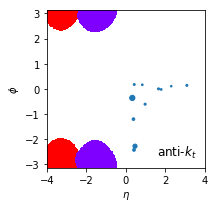

In [4]:
#Now, let's cluster some jets more efficiently!
all_largeRjets = {}
all_smallRjets = {}
all_largeRjets_ghost = {}
all_smallRjets_ghost = {}
all_hadrons = {}
all_hadrons_ghost = {}

fillGhost = True
eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200
kt, r, R=-1, 0.4, 1.0
pcut = 20
for mytype in ['background','signal']:
    all_largeRjets[mytype]=[]
    all_smallRjets[mytype]=[]
    all_largeRjets_ghost[mytype]=[]
    all_smallRjets_ghost[mytype]=[]
    all_hadrons[mytype]=[]
    all_hadrons_ghost[mytype]=[]
    
    for ievt in range(1): #len(events_combined)):
        if ievt%10000==0:
            print(mytype,ievt)
        issignal = events_combined[ievt][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[ievt][::3] if x > 0]), dtype=DTYPE_PTEPM)
        events_filled = events_combined[ievt][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

        pseudojets_input['pT'], pseudojets_input['eta'], pseudojets_input['phi'] = events_filled[:, 2], events_filled[:, 0], events_filled[:, 1]
        
#         pseudojets_input2 = pseudojets_input
        largeR = cluster(pseudojets_input, R=R, p=kt)
        largeRjets = largeR.inclusive_jets(ptmin=20)
        
#         smallR = cluster(pseudojets_input, R=r, p=kt)
#         smallRjets = smallR.inclusive_jets(ptmin=pcut)
        
        all_largeRjets[mytype] += [largeRjets]
#         all_smallRjets[mytype] += [smallRjets]
        all_hadrons[mytype] += [pseudojets_input]
        
        if fillGhost:
            # define eta and phi ranges and number of bins along each axis

            # create regular grid of ghosts
            eta_edges = np.linspace(eta_min, eta_max, bins + 1)
            phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
            eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
            phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
            X, Y = np.meshgrid(eta, phi)
            ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
            ghosts['pT'], ghosts['eta'], ghosts['phi'] = 1e-8, X.ravel(), Y.ravel()
            
            pseudojets_input_ghost = np.concatenate([pseudojets_input, ghosts])
#             print('pseudojets_input_ghost', len(pseudojets_input_ghost), pseudojets_input_ghost)
#             print('pseudojets_input', len(pseudojets_input), pseudojets_input)
            
            largeR_ghost = cluster(pseudojets_input_ghost, R=R, p=kt)
            largeRjets_ghost = largeR_ghost.inclusive_jets(ptmin=pcut)
            all_largeRjets_ghost[mytype] += [largeRjets_ghost]
            all_hadrons_ghost[mytype] += [pseudojets_input_ghost]


#             smallR_ghost = cluster(pseudojets_input_ghost, R=0.4, p=-1)
#             smallRjets_ghost = smallR_ghost.inclusive_jets(ptmin=20)

#             all_smallRjets_ghost[mytype] += [smallRjets_ghost]


        
        
        fig = plt.figure(figsize=(9, 3))

        # cluster
        sequence = cluster(pseudojets_input_ghost, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)
        print('jets',jets)
        print('largeRjets',largeRjets)
        largeRjets = jets

        ax = None

        # pick a different color for each jet
        colors = cm.rainbow(np.linspace(0, 1, len(largeRjets)))
        cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
        ax = fig.add_subplot(1, 1, 1, sharey=ax)
        area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                        dtype=np.float64)
        for ijet, jet in enumerate(largeRjets):
            constit = jet.constituents_array()
            jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                           bins=(eta_edges, phi_edges))
            area += (jetarea > 0) * (ijet + 1)

        # plot all areas
        ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
                  extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
                  interpolation='none', origin='lower')

        # overlay original event
        particles = pseudojets_input
        ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
        ax.set_xlim(extent[:2])
        ax.set_ylim(extent[2:])
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

        ax.text(0.95, 0.05, r'anti-$k_t$',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            fontsize=12)

        fig.subplots_adjust(hspace=0)
        plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
        fig.tight_layout()

In [6]:
def getJet(alljets, index):
    jet = {}
    for mytype in ['background','signal']:
        jet[mytype]={'pt':[], 'eta':[], 'phi':[]}
        for ievt in range(len(all_largeRjets[mytype])):
            jet[mytype]['pt'] += [alljets[mytype][ievt][index].pt]
            jet[mytype]['eta'] += [alljets[mytype][ievt][index].eta]
            jet[mytype]['phi'] += [alljets[mytype][ievt][index].phi]
    return jet

# lead_largeRjets, sublead_largeRjets = getJet(all_largeRjets, 0), getJet(all_largeRjets, 1)
# lead_smallRjets, sublead_smallRjets = getJet(all_smallRjets, 0), getJet(all_smallRjets, 1)
# print(lead_largeRjets)
# print(sublead_largeRjets)
# print(lead_smallRjets)
# print(sublead_smallRjets)


In [7]:
print(all_largeRjets['background'])

[[PseudoJet(pt=38.716, eta=-1.682, phi=-3.034, mass=21.279), PseudoJet(pt=20.657, eta=-3.353, phi=-2.948, mass=7.048)]]


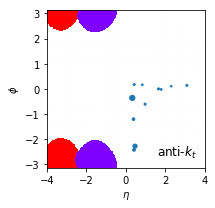

In [8]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

def plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = 'background', ievt = 0):
    event = all_largeRjets_ghost[mytype][ievt]

    fig = plt.figure(figsize=(9, 3))

    ax = None

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(event)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 1, 1, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(event):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = all_hadrons_ghost[mytype][ievt]
#     print('particles', len(particles), particles['eta'], particles['phi'])
#     print('event',len(event))
    ax.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.set_ylabel(r'$\phi$')
    ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, r'anti-$k_t$',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
    fig.tight_layout()
    
# print(len(all_hadrons_ghost['background'][0]), len(all_largeRjets_ghost['background'][0]), len(constituents_array))
# print(len(all_hadrons['background'][0]), len(all_largeRjets['background'][0]))
plot_jet_area(all_hadrons_ghost = all_hadrons_ghost, all_largeRjets_ghost = all_largeRjets_ghost, mytype = 'background', ievt = 0)
# plot_jet_area(all_hadrons_ghost = all_hadrons, all_largeRjets_ghost = all_largeRjets, mytype = 'background', ievt = 0)

{'background': [array([( 2.73766923e+00, 0.32410094, -0.36115795, 0.),
       ( 7.29829907e-01, 0.40985909, -2.42993855, 0.),
       (-1.16131008e+00, 0.86792219, -2.26777697, 0.), ...,
       ( 1.00000000e-08, 3.9       ,  3.12588469, 0.),
       ( 1.00000000e-08, 3.94      ,  3.12588469, 0.),
       ( 1.00000000e-08, 3.98      ,  3.12588469, 0.)],
      dtype=[('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8')])], 'signal': []}
[( 2.73766923e+00, 0.32410094, -0.36115795, 0.)
 ( 7.29829907e-01, 0.40985909, -2.42993855, 0.)
 (-1.16131008e+00, 0.86792219, -2.26777697, 0.) ...
 ( 1.00000000e-08, 3.9       ,  3.12588469, 0.)
 ( 1.00000000e-08, 3.94      ,  3.12588469, 0.)
 ( 1.00000000e-08, 3.98      ,  3.12588469, 0.)]


AttributeError: 'numpy.void' object has no attribute 'constituents_array'

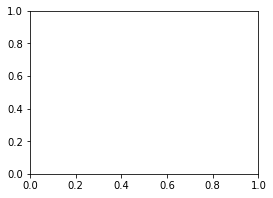

In [8]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

def plot_jet_area(alljets = all_largeRjets, mytype = 'background', ievt = 0):
    event = alljets[mytype][ievt]
    # pick a different color for each jet
    fig = plt.figure(figsize=(9, 3))
    colors = cm.rainbow(np.linspace(0, 1, len(event)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    
    # create regular grid of ghosts
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
    phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
    X, Y = np.meshgrid(eta, phi)
    ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
    ghosts['pT'] = 1e-8
    ghosts['eta'] = X.ravel()
    ghosts['phi'] = Y.ravel()

    
    ax = None
    ax = fig.add_subplot(1, 2, 1, sharey=ax)
    area = np.zeros((10,10), dtype=np.float64)

    print(alljets[mytype][ievt])
    for ijet, jet in enumerate(alljets[mytype][ievt]):
        constit = jet.constituents_array()
        print(ijet, len(constit))
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       )
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = event
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.set_ylabel(r'$\phi$')
    ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, 'Background',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

print(all_hadrons_ghost)
plot_jet_area(alljets = all_hadrons_ghost, mytype = 'background', ievt = 0)

NameError: name 'lead_largeRjets' is not defined

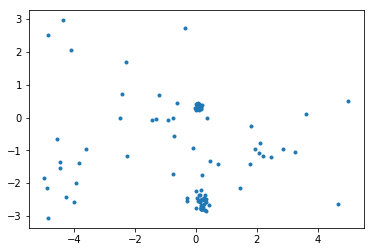

In [10]:
#Let's make some very simple plots.
def plothadron():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    n,b,p = plt.hist(pseudojets_input['eta'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.xlabel(r'$\eta$')
    plt.ylabel('Number of hadrons')
    plt.legend(loc='upper right')

def plothadron2d():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
#     plt.hist2d(x=pseudojets_input['eta'], y=pseudojets_input['phi'], bins=50, facecolor='r', label='background')
    plt.scatter(x=pseudojets_input['eta'], y=pseudojets_input['phi'], marker='.', label='Hadron')
    plt.scatter(x=lead_largeRjets['background']['eta'], y=lead_largeRjets['background']['phi'], marker='o', label='Hadron')
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    plt.legend(loc='upper right')
    
plothadron2d()
print(len(pseudojets_input))

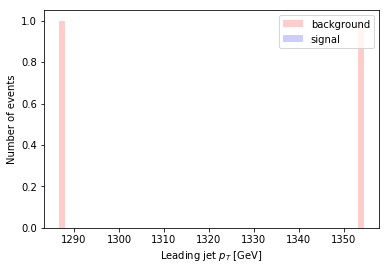

In [26]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT_largeRjets['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT_largeRjets['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

In [12]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(all_largeRjets[mytype])):
        E = all_largeRjets[mytype][k][0].e+all_largeRjets[mytype][k][1].e
        px = all_largeRjets[mytype][k][0].px+all_largeRjets[mytype][k][1].px
        py = all_largeRjets[mytype][k][0].py+all_largeRjets[mytype][k][1].py
        pz = all_largeRjets[mytype][k][0].pz+all_largeRjets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


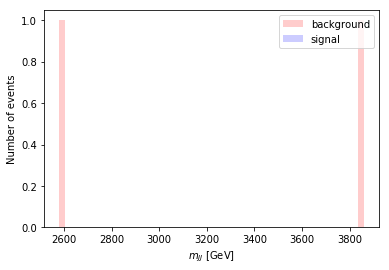

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")